# Uplift Modeling Analysis & Evaluation - Intro

This tutorial demonstrates how the `uplift-analysis` package can be used for analyzing and evaluating uplift models.

## Preliminaries

We'll start by importing the required libraries:

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout' : True,
                 'figure.figsize' : [15, 8.5],
                 'font.size': 17})
from typing import Tuple,Dict,Union
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from uplift_analysis import scoring,evaluation,visualization,data

Next, we initiate the numpy random generator, and assign some parameters:

- `num_treatments` - the number of possible non-neutral actions.
- `num_samples` - the number of observations composing each of the datasets we'll use.
- `binary_thresh` - we'll start by generating some stochastic continous response variable, and use this threshold value for transfroming it into a binary response variable.

*Note*: During this tutorial the term **action** will be used interchangeably with **treatment**.

In [4]:
np.random.seed(2023)

num_treatments = 4
num_samples = 100000
binary_thresh = 5.0

### Synthetic Data Generation

For demonstrating the suggested methodologies, we'll need some appropriate data.<br/>
For that purpose, we employ a modified version of the setup suggested in the paper [_**"Uplift Modeling with Multiple Treatments and General Response Types**_"](https://arxiv.org/pdf/1705.08492.pdf), by *Yan Zhao*, *Xiao Fang* and *David Simchi-Levi*.

The schema according to which the synthetic data is generated assumes a $d$-dimensional space, and a set of $T$ treatments (excluding the neutral action or *no-action* treatment), where $d > T$.

The feature-space is structured as follows:

- The first $T$ features (out of $d$ in total), are the features that specify and are responsible for the treatment-dependent effect.
- The rest of the features, $x_i$ ($i=T+1,...,d$), are uniformly distributed in a range represented as a hyper-cube between $[v_{low},v_{high}]$ for each of these variables. Hence, $X_i \sim U[v_{low},v_{high}]$, for $i=T+1,...,d$.
- Correspondingly, and in order to allow a negative treatment effect as well, the first $T$ features, responsible for the effect associated with each treatment, are distributed in a zero-centered hyper-cube, as follows: $X_i \sim U[v_{low} - \frac{v_{low} + v_{high}}{2},v_{high} - \frac{v_{low} + v_{high}}{2}]$, for $i=1,...,T$ (fixed values of $v_{low}$ and $v_{high}$ are used for all $i$).

*Note*: On this section, we denote random variables using uppercase letters, and their realizations using lowercase letters.

Moreover, we consider a continuous response variable, modeled as follows:<br/>

$$
\begin{align}
Y = f(X) + E + \epsilon
\end{align}
$$

Components:

- $f(X)$ defines the systematic dependence of the response on the features (regardless of the intervention / treatment). In that case, $f$ is a mixture of $d$ exponential functions, defined as follows:
$$
\begin{align}
f(x_1,...,x_d) = \sum_{i=1}^{d} a^i \cdot exp\{-b_1^i |x_1 - c_1^i| - ... - b_d^i |x_d - c_d^i|\}
\end{align}
$$
where $a^i$, $b_j^i$ and $c_j^i$ are chosen randomly.

- $E$ is the treatment effect, and is unique for each treatment $t = 1,...,T$:
$$
\begin{align}
E(X,t)=
\begin{cases}
U[0,\alpha X_{t^*}] & \text{for $t=t^*$ and $X_{t^*} > 0$}\\
U[\alpha X_{t^*},0] & \text{for $t=t^*$ and $X_{t^*} < 0$}\\
0 & \text{otherwise}\\
\end{cases}
\end{align}
$$
so that the effect for assigned to an observation if it was assigned with the treatment $t^*$ is a random value, distributed uniformly between zero and the value of the corresponding attribute $X_{t^*}$, multiplied by $\alpha$ which sets the magnitude of the effect.

- $\epsilon$ is the zero-mean Gaussian noise, $\epsilon \sim \mathbb{N}(0,\sigma^2)$, where the standard deviation $\sigma$ is identical, regardless of the treatment.

Of course, there are other ways for creating synthetic datasets for the examination of uplift modeling techniques. Refer to this detailed [blogpost](https://humboldt-wi.github.io/blog/research/applied_predictive_modeling_19/data_generating_process_blogpost/#Theory-behind-the-package), by Julian Winkel and Tobias Krebs, for more details.

Let us implement and wrap the data generation scheme detailed above, with a class named `TreatmentEffectDataGenerator`:

In [5]:
class TreatmentEffectDataGenerator:
    """
    A class for generating random treatment effect data, according to a parametric scheme.
    
    Parameters
    ----------
    response_func: dict
        A dictionary containing the lower and upper boundaries for the random variables `a` and `b`.
        It contains the keys `a` and `b`, with corresponding values represented as two-value tuples.
    num_treatments: int
        The number of non-neutral actions/treatments.
    feat_dim: int
        The dimension of the feature space.
    hypercube_bounds: Tuple
        The bounds of the random variables composing the feature space.
    effect_magnitude: float
        A parameter which will scale the randomized effect, computed according to the relevant features,
        for yielding the final effect size for each observation.
    noise_var: float
        The standard deviation associated with the noise factor.
    treat_rate: Union[float,None]
        The rate in which treatments (excluding the neutral action) are assigned.
    """
    
    def __init__(self,
                 response_func: Dict,
                 num_treatments: int = 1,
                 feat_dim: int = 50,
                 hypercube_bounds: Tuple = (0, 10),
                 effect_magnitude: float = 0.3,
                 noise_std: float = 0.8,
                 treat_rate:Union[float,None] = None):

        self.a_bounds = response_func['a']
        self.b_bounds = response_func['b']
        
        assert feat_dim > num_treatments

        self.num_treatments = num_treatments
        self.feat_dim = feat_dim
        self.hypercube_bounds = hypercube_bounds
        self.effect_magnitude = effect_magnitude
        self.noise_std = noise_std
        
        assert treat_rate is None or 0 < treat_rate < 1.0
        self.treat_rate = treat_rate
        

        # set the random parameters defining the systematic dependence
        # between the response and the feautre space.
        self.a = np.random.uniform(low=self.a_bounds[0], high=self.a_bounds[1],
                                   size=(self.feat_dim,))
        self.b = np.random.uniform(low=self.b_bounds[0], high=self.b_bounds[1],
                                   size=(self.feat_dim, self.feat_dim))
        self.c = np.random.uniform(low=self.hypercube_bounds[0],
                                   high=self.hypercube_bounds[1],
                                   size=(self.feat_dim, self.feat_dim))

    def generate(self, num_samples: int) -> Dict:
        """
        The interface method of the class, for generating a sample composed of a desired quantity of
        randomized observations, sampled according to the parametric data model.
        
        Parameters
        ----------
        num_samples: int
            The number of observations required.
            
        Returns
        ----------
        Dict[str,np.ndarray]
            A dictionary holding the following keys: ``feats`` - the feature vector associated with each
            observation, ``treatments`` - the randomly assigned treatments, ``f`` - the systematic dependence
            between the response variable and the features, ``treatment_effect`` - the random treatment effect
            computed and sampled according to the assigned treatment, and ``response``- the resulting response
            variable according to the data model, and the sampled factors.        
        """
        
        # according to the configured hyper-cube bounds, calculate the center value
        cube_mid = (self.hypercube_bounds[0] + self.hypercube_bounds[1]) / 2
        # for creating the offset bounds of the features responsible for the causal effect:
        effect_feats = np.random.uniform(low=self.hypercube_bounds[0] - cube_mid,
                                  high=self.hypercube_bounds[1] - cube_mid,
                                  size=(num_samples,self.num_treatments))
        # the rest of the features are sample according to the prescribed setting
        other_feats = np.random.uniform(low=self.hypercube_bounds[0],
                                  high=self.hypercube_bounds[1],
                                  size=(num_samples, self.feat_dim - self.num_treatments))
        # then we concatenate both for creating the union feature set
        feats = np.concatenate((effect_feats,other_feats),axis=1)
        
        # assign treatments randomly (zero is also an option - corresponding to no-action / neutral action)
        if self.treat_rate is None: # uniform choice
            treatments_assignment = np.random.randint(self.num_treatments + 1,
                                                  size=(num_samples,))
        else:
            no_action_rate = 1 - self.treat_rate
            weights = [no_action_rate] + [self.treat_rate / num_treatments] * num_treatments
            treatments_assignment = np.random.choice(np.arange(self.num_treatments + 1),
                                                     replace=True, p=weights, size=(num_samples,))
                
        # compute systematic dependence
        f = 0
        for idx in range(self.feat_dim):
            expit = -np.dot(np.abs(feats - self.c[idx, ...]), self.b[idx, ...])
            f += self.a[idx] * np.exp(expit)
        
        # compute and sample treatment effect
        treatment_effect = 0
        for idx in range(self.num_treatments):
            treatment_indicator = (treatments_assignment == idx + 1).astype(float)
            treatment_effect += np.random.uniform(low=0.0, high=self.effect_magnitude * feats[..., idx]) * \
                                treatment_indicator
        # sample the noise
        noise = np.random.normal(scale=self.noise_std, size=(num_samples,))
        
        # aggregate all for the final response values
        response = f + noise + treatment_effect

        return {
            'features': feats,
            'treatments': treatments_assignment,
            'f': f,
            'treatment_effect': treatment_effect,
            'response': response
        }

Now, we can initalize the parameterized synthetic data generator, as follows:

In [6]:
dg = TreatmentEffectDataGenerator(response_func={'a': (0, 0.025), 'b': (-0.05, 0.0275)},
                                      num_treatments=num_treatments,
                                      feat_dim=50,
                                      hypercube_bounds=(0, 10),
                                      effect_magnitude=0.3,
                                      noise_std=0.8,
                                      treat_rate=0.5)

And use it for creating corresponding train and validation sets:

In [7]:
train_set = dg.generate(num_samples)
valid_set = dg.generate(num_samples)

Each of these sets is represented as dictionary of `numpy` arrays.

As noted earlier, our data generation process yields a continuous response variable $Y$. Using a suitable threshold value we can create a synthetic binary response variable:

In [8]:
train_set['binary_response'] = (train_set['response'] > binary_thresh).astype(int)
valid_set['binary_response'] = (valid_set['response'] > binary_thresh).astype(int)

#### A Brief Glance

Before moving on, let get a sneak peek at the datasets we created.

In [9]:
# creating dataframes to represent each set
train_df = pd.DataFrame({k:v for k,v in train_set.items() if k != 'features'})
valid_df = pd.DataFrame({k:v for k,v in valid_set.items() if k != 'features'})

Using these dataframes we can view the treatment assignment distribution (and verify that it matches the configuation according to which we initialized the data generator):

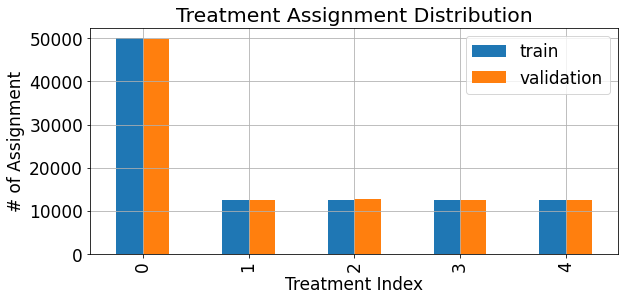

In [10]:
fig,ax = plt.subplots(figsize=(9,4.5))
assignments = pd.merge(train_df['treatments'].value_counts().rename('train'),
                       valid_df['treatments'].value_counts().rename('validation'),
                       left_index=True,right_index=True)
assignments.sort_index().plot(kind='bar',ax=ax)
ax.grid(True)
ax.set_xlabel('Treatment Index')
ax.set_ylabel('# of Assignment')
ax.set_title('Treatment Assignment Distribution')
plt.show()

We can also examine the distribution of the response variable, both overall, and for each treatment sepeartely:

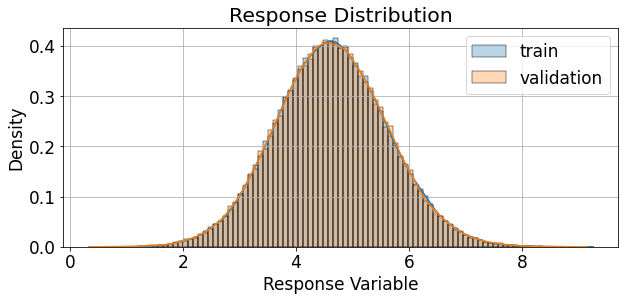

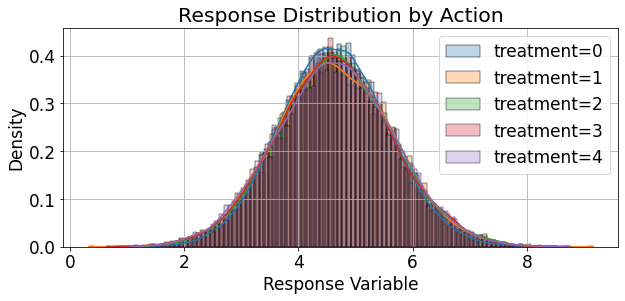

In [11]:
fig,ax = plt.subplots(figsize=(9,4.5))
palette = itertools.cycle(sns.color_palette())
sns.histplot(train_df['response'], ax=ax, kde=True, bins=100, stat='density', alpha=0.3,
             label='train',color=next(palette))
sns.histplot(valid_df['response'], ax=ax, kde=True, bins=100, stat='density', alpha=0.3,
             label='validation',color=next(palette))
ax.grid(True)
ax.legend()
ax.set_xlabel('Response Variable')
ax.set_ylabel('Density')
ax.set_title('Response Distribution')

palette = itertools.cycle(sns.color_palette())
fig,ax = plt.subplots(figsize=(9,4.5))
for treat, grp in valid_df.groupby('treatments'):
    sns.histplot(grp['response'], ax=ax, kde=True, bins=100, stat='density', alpha=0.3,
             label=f"treatment={treat}",color=next(palette))
ax.grid(True)
ax.legend()
ax.set_xlabel('Response Variable')
ax.set_ylabel('Density')
ax.set_title('Response Distribution by Action')
plt.show()

The response rate of the *binary version* (thresholded response) of the reponse can be described as follows:

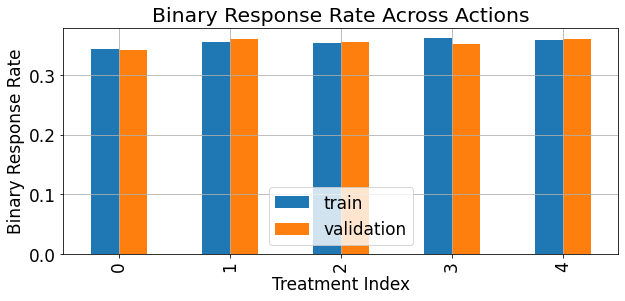

In [12]:
fig,ax = plt.subplots(figsize=(9,4.5))
ate = pd.merge(train_df.groupby('treatments')['binary_response'].mean().rename('train'),
               valid_df.groupby('treatments')['binary_response'].mean().rename('validation'),
               left_index=True,right_index=True)
ate.sort_index().plot(kind='bar',ax=ax)
ax.grid(True)
ax.set_xlabel('Treatment Index')
ax.set_ylabel('Binary Response Rate')
ax.set_title('Binary Response Rate Across Actions')
plt.show()

As demonstrated below, the average treatment effect ($ATE$) associated with each treatment, in our syntetic data simulation is of really small magnitude compared to the magnitude and scale of the response:

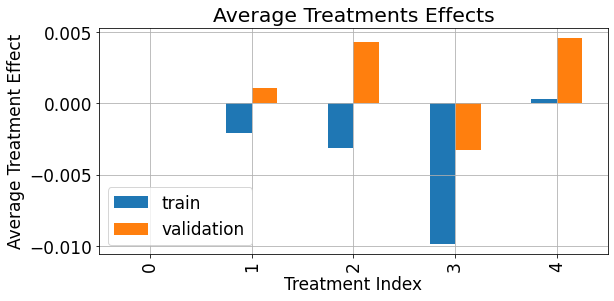

In [13]:
fig,ax = plt.subplots(figsize=(9,4.5))
ate = pd.merge(train_df.groupby('treatments')['treatment_effect'].mean().rename('train'),
               valid_df.groupby('treatments')['treatment_effect'].mean().rename('validation'),
               left_index=True,right_index=True)
ate.sort_index().plot(kind='bar',ax=ax)
ax.grid(True)
ax.set_xlabel('Treatment Index')
ax.set_ylabel('Average Treatment Effect')
ax.set_title('Average Treatments Effects')
plt.show()

### Acquiring Uplift Scores

The domain of *Uplift Modeling* refers to a collection of methodologies for solving personalized treatment selection problems. In these problems, the model aims to predict the optimal treatment based on given subject characteristics.
The general setup includes:

- $\boldsymbol{X}$: A set of an observation-level covariates, e.g. medical history records patients.
- $T$: The assigned treatment/action/intervention assigned to each observation, e.g. the medication given to each patient, if at all.
- $y$: The response variable observed after assigning the treatment $t \in T$ to context $\boldsymbol{x} \in \boldsymbol{X}$, e.g. the health condition of the patient after $N$ days. We'll assume higher response value is *better* (for continuous response variables), and for binary response variables a response of 1 is the desired outcome.

Using the data $(\boldsymbol{X}, T, \boldsymbol{y})$, an uplift model is trained for creating some kind of *policy*, a treatment assignment policy, that will use $\boldsymbol{x}$ to assign $t \in T$, in order to maximize the value of $y$.<br/>
In some sense, this type of problem puts the *uplift modeling* under the *umbrella* of **Causal Inference**. For more information regarding this topic, one can refer to the paper [*"A survey and benchmarking study of multitreatment uplift modeling*"](https://link.springer.com/article/10.1007/s10618-019-00670-y), by Diego Olaya, Kristof Coussement & Wouter Verbeke, as an example - but there are lots of literature resources for more details on this domain. 

Besides the optimal treatment predicted by the uplift model for each observation, one more output of the model is termed the *uplift score*, which will be denoted as $\hat{u}_i$, for the $i^{th}$ observation. This score is often used to handle the prioritization of treatment assignment; to give high priority to observations that are expected to benefit the most from the suggested treatment, and low priority to observations that are expected to have low benefit (or even a negativee effect), w.r.t to the response variable, due to the treatment.

Often, the *uplift score* (also known as the *uplift signal*) the model outputs, is a proxy, or an estimation of the **Conditional Average Treatment Effect** (or __**CATE**__):

$$
\begin{align}
\tau ( \boldsymbol{t}^{'},\boldsymbol{t}, \boldsymbol{x}) \mathrel{\mathop:} = \mathop{\mathbb{E}} \left[ Y | \boldsymbol{X} = \boldsymbol{x}, \boldsymbol{T} = \boldsymbol{t}^{'}  \right] - \mathop{\mathbb{E}} \left[ Y | \boldsymbol{X} = \boldsymbol{x}, \boldsymbol{T} = \boldsymbol{t}  \right]
\end{align}
$$

which quantifies how different will be the expected outcome/response for a covariate vector $\boldsymbol{x}$, under the treatment $\boldsymbol{t}^{'}$, compared to another treatment $\boldsymbol{t}$. The treatment $\boldsymbol{t}$ can serve as the reference action, the neutral action, or for indicating no-action at all. The neutral action is denoted as $t_0$

As the goal of this tutorial is to demonstrate the *evaluation* of uplift models, modeling techniques will not be covered here too deeply, and the reader is referred to surveys such as [this paper](https://link.springer.com/article/10.1007/s10618-019-00670-y) for more details.

Instead, we will use quite simple, naive, and not too complex modeling approaches for demonstration purposes. The approaches applied in this tutorial are part of a broader set of techniques for uplift modeling, termed as <ins>***Meta-Learners*** </ins>.
A *Meta-Learner* in the context of uplift modeling, employs possibly multiple *base-learners*, and combines their outputs for estimating the final *CATE*. Each base-learner, which can be represetned by any learning algorithm, used supervised learning, for a specific prediction task.

Here are two examples of Meta-learners:

- <ins>***T-Learner***</ins> takes a *separate-model* approach (also known as *SMA*), according to which the *CATE* is estimated by:
$$
\begin{align}
\tau ( \boldsymbol{t}^{'},\boldsymbol{t}, \boldsymbol{x}) \mathrel{\mathop:} = \hat{\mu}_{\boldsymbol{t}^{'}}(\boldsymbol{x}) - \hat{\mu}_{\boldsymbol{t}}(\boldsymbol{x})
\end{align}
$$
where $\hat{\mu}_{\boldsymbol{t}}(\boldsymbol{x})$ is a model, represented by a base-learner, which is responsible for learning $\mathop{\mathbb{E}} \left[ Y | \boldsymbol{X} = \boldsymbol{x}, \boldsymbol{T} = \boldsymbol{t}  \right]$, and is exposed, during its training phase, only to observations assigned with the treatment $\boldsymbol{t}$.
This meta-learner is relatively simplistic, and fail to perform in many scenarios, compared to other advanced meta-learners, such as [*X-Learner*](https://www.pnas.org/content/116/10/4156) and [*R-Learner*](https://arxiv.org/abs/1712.04912).

- <ins>***S-Learner***</ins> in which the treatment indicator is included as a feature, similarly to all of the other features, without the indicator being given any special role. Thus, it employs a <ins>single model</ins> which expects as input also the identity of the action assigned to the observation:
$$
\begin{align}
\tau ( \boldsymbol{t}^{'},\boldsymbol{t}, \boldsymbol{x}) \mathrel{\mathop:} = \hat{\mu}(\boldsymbol{x},\boldsymbol{\boldsymbol{t}^{'}}) - \hat{\mu}(\boldsymbol{x},\boldsymbol{\boldsymbol{t}})
\end{align}
$$
where the base-learner $\hat{\mu}(\boldsymbol{x},\boldsymbol{\boldsymbol{t}})$ is defined as:
$$
\begin{align}
\hat{\mu}(\boldsymbol{x},\boldsymbol{\boldsymbol{t}^{*}}) \mathrel{\mathop:} = \mathop{\mathbb{E}} \left[ Y | \boldsymbol{X} = \boldsymbol{x}, \boldsymbol{T} = \boldsymbol{t}^{*}  \right]
\end{align}
$$

Let us apply these concepts for retrieving uplift scores for enabling the evaluation process.

We will consider:

- A single type of meta-learner: the *T-learner*.
- The two types of response variables available in our datasets: binary and continuous.
- Two possiblities for base-learners: Gradient-Boosting Decision-Tree (*GBDT*) ensemble, or a simple linear learner (linear regression for the continuous response variable, or logistic regression for the binary response variable).

#### T - learner

As noted above, for the *T-learner* we train separate models for each treatment, where each model is exposed during training only to observerations that were assigned to a specific treatment.

In [14]:
# accumulate treatment-dependet models for each case:
t_gbdt_cont_models = []  # response: continuous, base-learner: gbdt
t_linear_cont_models = []  # response: continuous, base-learner: linear
t_gbdt_bin_models = []  # response: binary, base-learner: gbdt
t_linear_bin_models = []  # response: binary, base-learner: linear

print('Training')

# for each treatment
for treat in tqdm(range(num_treatments + 1)):
    # get the subset of observations related to the treatment
    subset_idx = train_set['treatments'] == treat
    
    # train the treatment-dependent response model
    t_gbdt_cont_models.append(GradientBoostingRegressor(n_estimators=10).fit(X = train_set['features'][subset_idx],
                                                                            y = train_set['response'][subset_idx]))
    
    t_linear_cont_models.append(LinearRegression().fit(X = train_set['features'][subset_idx],
                                                       y = train_set['response'][subset_idx]))
    
    t_gbdt_bin_models.append(GradientBoostingClassifier(n_estimators=10).fit(X = train_set['features'][subset_idx],
                                                                            y = train_set['binary_response'][subset_idx]))
    
    t_linear_bin_models.append(LogisticRegression().fit(X = train_set['features'][subset_idx],
                                                        y = train_set['binary_response'][subset_idx]))



Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.87s/it]


Using the trained models, we retrieve the estimations of the response variable, associated with each treatment, and stack them as numpy arrays, which will be included in the dictionary representing our validation set (each model will have a dedicated key):

In [15]:
# accumulate treatment-dependet estimations for each case:
t_gbdt_cont_outputs = [] # response: continuous, base-learner: gbdt
t_linear_cont_outputs = [] # response: continuous, base-learner: linear
t_gbdt_bin_outputs = [] # response: binary, base-learner: gbdt
t_linear_bin_outputs = [] # response: binary, base-learner: linear

# for each treatment
for treat in tqdm(range(num_treatments + 1)):
    # apply the treatment-dependent response model on the entire dataset
    t_gbdt_cont_outputs.append(t_gbdt_cont_models[treat].predict(valid_set['features']))
    t_linear_cont_outputs.append(t_linear_cont_models[treat].predict(valid_set['features']))
    
    # in the case of binary response - `predict()` is replaced with `predict_proba()`
    t_gbdt_bin_outputs.append(t_gbdt_bin_models[treat].predict_proba(valid_set['features'])[:,-1])
    t_linear_bin_outputs.append(t_linear_bin_models[treat].predict_proba(valid_set['features'])[:,-1])
    
valid_set['t_learner_gbdt_cont'] = np.stack(t_gbdt_cont_outputs,axis=-1)
valid_set['t_learner_linear_cont'] = np.stack(t_linear_cont_outputs,axis=-1)
valid_set['t_learner_gbdt_bin'] = np.stack(t_gbdt_bin_outputs,axis=-1)
valid_set['t_learner_linear_bin'] = np.stack(t_linear_bin_outputs,axis=-1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


# Scoring
`uplift-analysis.scoring` is a module that implements the class `Scorer`. The `Scorer` class is used for abstracting the procedure of uplift score computation, in case it is not provided directly by the model (just like in *T-learner* or *S-learner*). It can be used for scoring a gived dataset, according to a provided configuration (or a set of configurations). Each configuration, should specify the relevant fields according to which the score is computed, and the function to apply to these fields.<br/>
<ins>*Note*</ins>: using the `Scorer` is optional, and it is not obligatory for the rest of the evaluation procedure. It is only used to facilitate the scoring phase.

We'll start by scoring only a single model - the binary response *T-learner* using *GBDT* as a base-learner:

In [16]:
t_gbdt_bin_scorer = scoring.Scorer({
    'scoring_func': 'binary_score_calc',
    'name': 't_gbdt_bin',
    'scoring_field': 't_learner_gbdt_bin',
    'reference_field': 't_learner_gbdt_bin',
    'reference_idx': 0,
    })

The `scoring_func` key represent the `Callable` object defining the functionality applied for computing the score. It can be either one of the scoring functions implemented as part of the scorer: `binary_score_calc`,`sigmoid_frac_score_calc`, `cont_score_calc`, `identity_score_calc`, or any other user-defined function (for configuring one of the pre-defined function, one can specify the associated function name as a string).
In addition, `scoring_field` specifies the field according to which the scoring is performed, and the `reference_field`, and `reference_idx` specifies the field and the column index used for inferring the base/reference response estimated, if it is required for computing the scores.

Then, applying the scorer for calculating the scores:

In [17]:
ranking, recommended_action, score, action_dim = t_gbdt_bin_scorer.calculate_scores(dataset=valid_set)

we get:

- `ranking`: The relative rank $\in (0,1]$ associated with each observation in the dataset w.r.t to the uplift score, where the highest rank corresponds to the highest score.
- `recommended_action`: The serial index of the action associated with the highest uplift score, for each observation - inferred as the recommended treatment by the model.
- `score`: The computed uplift score, for each observation, according to the provided configuration.
- `action_dim`: The quantity of actions (action space cardinality) taken into account during scoring (including the neutral/no-action).

# Evaluation

An uplift model can be considered as a dynamic and continuous policy $\pi(\boldsymbol{x},q)$. $\boldsymbol{x}$ represents the context / the featre vector associated with an observation, $q$ can be treated as the rate of exposure of the model's recommendations (further elaboration to follow), and $\pi$ is a function of both which outputs the actual action - whether or not to assign a treatment to the observation, and which treatment it will be.<br/>
Usually the considered treatments are associated with some cost, and in most of the cases assigning treatments (that are not the neutral action) to the entire population is not feasible. Moreover, some of the observations might be associated with negative effects as a result of a/the treatment.<br/>

As noted the uplift score is used to serve as a proxy measure for the positive effect estimated and associated with a specific treatment. Hence, higher uplift scores imply higher magnitude (more positive) effect on the response variable.<br/>

Hence, the variable $q$, controlling $\pi(\boldsymbol{x},q)$, corresponds to the <ins>*exposure rate*</ins> of the recommendations of the model, in terms of score quantiles. It means, that the upper $q$ quantiles of the scores are exposed to the recommendations of the model, and the rest of the population, associated with lower scores, are not exposed to the recommendations, and get the default/netural/no-action treatment, noted from now on as $t_0$.<br/>

Therefore, each upper quantile $q=q^{*} \in (0,1)$, can also be interpreted by a corresponding threshold, given the distribution of uplift scores, $\boldsymbol{\hat{u}}$, observed among the validation set. The corresponding threshold is defined as follows:
$$
\begin{align}
Thresh(q^{*},\boldsymbol{\hat{u}})=p_{q^{*}}, \hspace{0.5cm} \text{for} \hspace{0.5cm} \frac{1}{N} \sum_{i=1}^{N} \mathbb{1} \left[ \hat{u}_i \geq p_{q^{*}} \right] = q^{*}
\end{align}
$$
where $N$ denotes the number of observations in the evaluated dataset, and $\mathbb{1}$ denotes the indicator function.

Accordingly, for each value of $q=q^{*} \in (0,1)$, the dynamic policy $\pi(\boldsymbol{x},q)$ is fixed as $\pi(\boldsymbol{x},q^{*}) = h_{q^{*}}(x)$, which is mapping from the feature space to the space of treatments, i.e. $h(\cdot) : \mathbb{X}^d \rightarrow \{t_0,t_1,...,t_T \}$. Each fixed mapping $h_{q^{*}}(x)$ assigns the treatments recommended by the model to observations associated with high uplifts scores, or more precisely to observations associated with uplift scores that are in the upper $q^{th}$ quantile of the score distribution (those with $\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}})$), and assigns the neutral action to the rest of the distribution (where $\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}})$).

Each value of $q=q^{*} \in (0,1)$, and the corresponding $h_{q^{*}}(x)$ and $Thresh(q^{*},\boldsymbol{\hat{u}})$, define what will be termed as the <ins>*acceptance region*</ins> - the range of scores, $\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}})$ , in which the model (or the resulting *policy*) aims to assign a treatment (non-neutral action, action different than $t_0$), and the complement <ins>*rejection region*</ins> - the range of scores, $\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}})$, where the model will assign the neutral treatment $t_0$.

## Representing Evaluation Sets with `EvalSet` objects

Equipped with this terminlogoy, we will create a corresponding `EvalSet` object (implemented in `uplift_analysis.data`). `EvalSet` is a dataclass used to represente a dataset object, going through the uplift evaluation procedure, together with the corresponding meta-data.<br/>
For creating, a `pandas.DataFrame` is required, along with the specification of the following:

- `observed_action_field`: The name associated with the field / column containing the actual action assigned for each observation in the evaluated set.
- `response_field`: The name associated with the field / column containing the observed response for each observation in the evaluated set.
- `score_field`: The name associated with the field / column containing the output score for each observation in the evaluated set.
- `proposed_action_field`: The name associated with the field / column containing the recommended action by the model, for each observation in the evaluated set.
- `control_indicator`: The action value associated with the neutral action.

In [18]:
scored_df = pd.DataFrame({
    'recommended_action': recommended_action,
    'score': score,
    'observed_action': valid_set['treatments'],
    'response': valid_set['binary_response'],
    })

eval_set = data.EvalSet(
    df=scored_df,
    observed_action_field='observed_action',
    response_field='response',
    score_field='score',
    proposed_action_field='recommended_action',
    control_indicator=0,
    )

## Performance Evaluation Using `Evaluator`

For performing the evaluation procedure of the dataset represented as an `EvalSet` object, we employ an `Evaluator` object (implemented under `uplift_analysis.evaluation`).

In [19]:
evaluator = evaluation.Evaluator()
eval_res,summary = evaluator.evaluate_set(eval_set)

As a result of the evaluation, we get:

- `eval_res`: The resulting `EvalSet` on which the evaluation was performed.
- `summary`: A gross statistics summary of the evaluation process (the values contained in this summary will be elaborated [later in this tutorial](#Evaluation-Summaries)).

## Inspect Treatment Assignment
Before visualizing the evaluated performance, it can be very useful to examine how the treatments are distributed according to the model.<br/>
It can easily expose tendencies of the model to prefer a specific treatment, or a region of the score distribution, in which other treatments are preferred by the model. Insights such as these can expose other pitfalls or strengths of the model.<br/>
For describing the assignment of treatments and their distribution, we show the cumulative sum of assignments for each treatment, as the accepatance-region is expanded, and the score threshold goes lower.

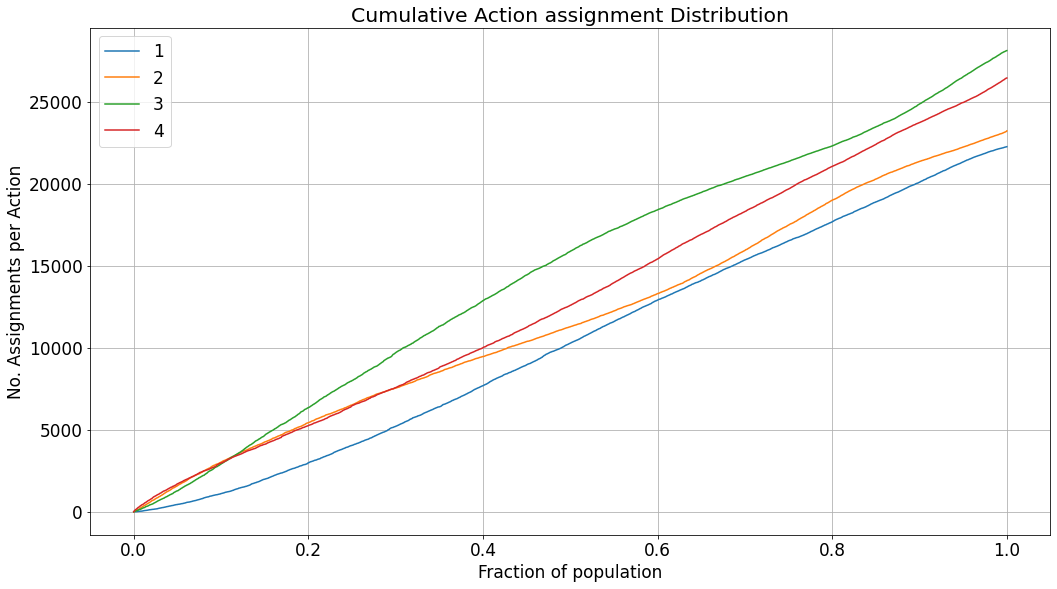

In [20]:
_ = visualization.visualize_selection_distribution(eval_res)

In the case of the dataset we generated, there should not be any preference towards a specific treatment, thus the assignment rate is quite similar across all the treatments. However, in real-life scenarios, preferences of the model will be easily observed in a similar chart.

<a id='operating'></a>

### Inspect Operating Point Treatment Assignment Distribution

In practice, when an uplift model is deployed for treatment assignment on new observations, the score threshold $p_{q^{*}}$ should also be specified. The threshold defines the bounds of the acceptance region w.r.t uplift score.<br/>
In inference, the acceptance region cannot be defined using the specification of the upper quantile $q=q^{*} \in (0,1)$. As opposed to the *offline* evaluation of the validation dataset, in the phase of inference, we won't necessarily be exposed to a distribution of samples; possibly only to a single instance (in streaming use-cases), for which the model will need to decide, whether to apply the recommendation of the model or not. Thus, in practice, a score threshold, inferred according to the observed distribution of uplift scores would be used.
Thresholding and bounding the acceptance region of model recommendations, might be required due to multiple reasons. Two prominent reasons could be i) budget limitations which prohibit the assignment of treatments (which impose some cost) to the entire population, or ii) a negative effect on the response due to the treatment for specific segments of the population (termed in the literature as "*sleeping dogs*").<br/>

The selected threshold applied to new instances, as part of the deployment of the model, is termed as the <ins>*operating point*</ins>. Inspecting the assignment distribution under the chosen *operating point* can also be useful:

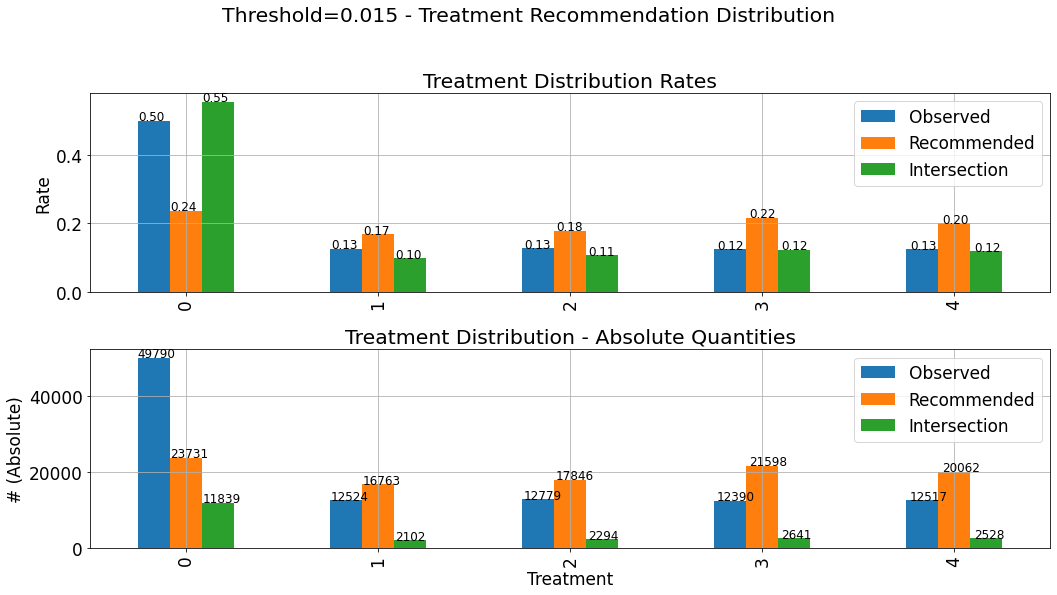

In [21]:
_ = evaluator.get_distribution_by_threshold(eval_set,thresh=0.015)

These charts describe the distribution of assigned treatments among three different groups:

- `Observed`: The actual treatments assigned to the observations composing the evaluated dataset. This distribution is not affected by the choice of the specific threshold.
- `Recommended`: The distribution of the recommendations of the the policy $\pi(\boldsymbol{x},q^{*}) = h_{q^{*}}(x)$ corresponding to the selected threshold.
- `Intersection`: The distribution of actions in the intersection set between the observed actions and the ones recommended by the model, i.e where the recommendation of the model $h_{q^{*}}(x)$ goes hand-in-hand with the observed treatment.

The upper subplot describes the density distribution, and the lower describes the distribution in absolute quantities. Thus, the bars associated with the `Intersection` group, on the lower chart (absolute quantities) will always be lower (or equal)in height than the `Recommended` group.<br/> 
As explained and demonstrated later in this tutorial, much of the evaluted performance measure relies on the statistics of the *Intersections* set. Therefore, it is important to verify that the distribution of assignments in the *Intersections* set is not significantly different from the "hypothetical" distribution of assignments (`Recommended`). If that is not the case, and the distributions are very different, we won't be able to "project" the performance we evaluated (based on the intersection set), and expect similar performance when the model will be deployed, and act on(assign treatments to) new instances.

## Visualize Evaluated Performance Using `Evaluator.visualize()`

Now, we can use the `evaluator` for visualizing the results of the evaluation, using the method `Evaluator.visualize()`.<br/>

<ins>*Note*</ins>: A dedicated method, `Evaluator.eval_and_show()`, can be used for combining the steps of <ins>*evaluation*</ins> and <ins>*visualization*</ins> with a single call.

The `Evaluator` class provides a set of charts for the visualization of the evaluated performance, listed under:

In [22]:
list(evaluator.visualization_methods().keys())

['uplift',
 'fractional_lift',
 'gain',
 'avg_response',
 'acceptance_region',
 'rejection_region',
 'agreements',
 'score_distribution']

All the charts listed above, except for `score_distribution`, share the same *x-axis*. As explained earlier, the performance of the uplift model is a function of the exposure rate, expressed by $q=q^{*} \in (0,1)$, which denotes the upper $q^{th}$ quantile of scores according to which observations (with scores in this range) will be exposed to the treatments recommended by the model.<br/>
Accordingly, each signal/measure depcited in these charts is a function of the upper $q^{th}$ quantile, and as we move from the left side of the chart towards the right, the <ins>*acceptance-region*</ins> gets wider, observations with lower scores enter the *acceptance-region*, and the performance, or the values of the specific metric depicted, might change. Of course, as the *acceptance-region* grows wider, and $q$ grows bigger, the *rejection-region* shrinks accordingly (as it complements the acceptance-region).<br/>
As an auxiliary notation, we denote the observed treatment assignment for the $i^{th}$ observation as $t^{(i)}$.

The created charts yield different visualizations, dependening on:

- whether the evaluated set is associated with multiple treatments or just a single binary treatment.
- whether the associated response is represented by a binary variable or a contrinuous variable.
- whether they are created for a single `EvalSet` object, or a collection of such (as will be demonstrated later in this tutorial).

Moreover, in the case of calling `Evaluator.visualize()` with a single `EvalSet` object, the user can set the keyword argument `show_random` and `num_random_rep` for benchmarking the depicted measure/metric relative to the average of the same metric over a collection of corresponding `EvalSet` objects that were randomly scored.

When calling `Evaluator.visualize()` all these charts will be provided, one after the other. However, the user can use the keyword argument `specify`, for *specifying* the list of charts desired. For explaining the content depicted in each chart, we'll use this option, to show each chart separately.

Let us start with the first chart:

<a id='uplift'></a>

### Uplift Curve 

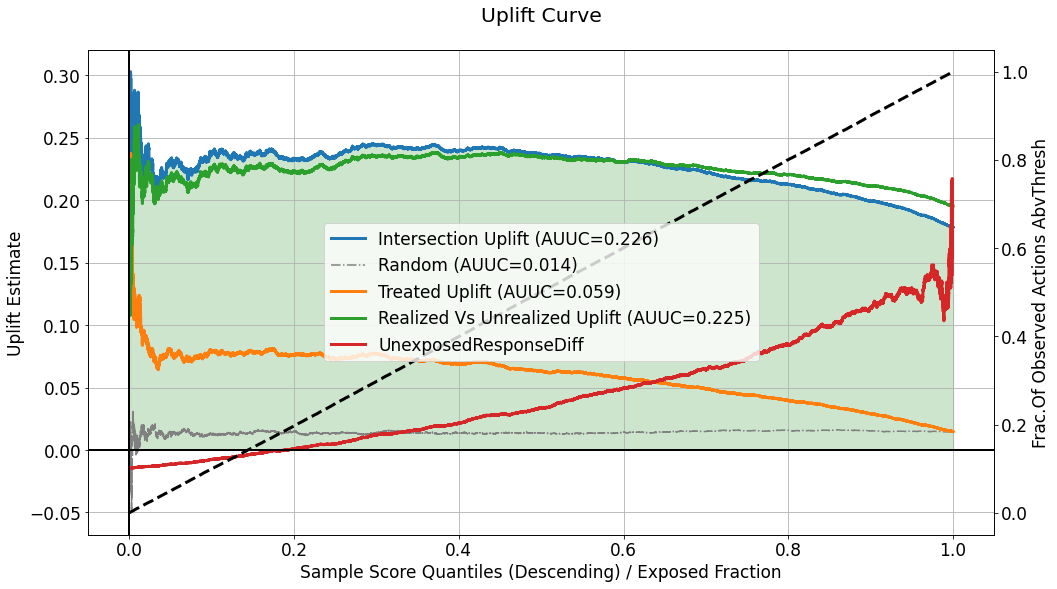

In [23]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['uplift'])

This chart describes several curves, but the primary one is the one labeled as `Intersection Uplift`, quantifying the **differnce**, <ins>within the *acceptance region*</ins> defined according to $q^{*}$, between :

- the **average response** for the group of observations for which the observed actions intersect with the treatments recommended by the model, i.e. $\mathop{\mathbb{E}} \left[ y_i | \hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} h_{q^{*}}(x^{(i)}) = t^{(i)}\right]$, which is estimated as: 
$$
\begin{align}
\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i > Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]}
\end{align}
$$

- the **average response** for the group of observations which were assigned with the neutral action $t_0$, i.e. $\mathop{\mathbb{E}} \left[ y_i | \hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} t^{(i)} = t_0 \right]$, which is estimated as: 
$$
\begin{align}
\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}
\end{align}
$$

As long as this uplift curve is positive, it implies higher average response for the intersection group, compared to the untreated group, within the acceptance region. The left edge on the curve describes the difference when a very small fraction of the score distribution is exposed to the decisions of the model, and the right edge describes a scenario in which the entire population is exposed to the recommendation.

The label attached to the curve also indicates the area under the curve which is often used as an aggregate performance metric. The area under the curve is also color-filled (green will be the fill color for positive values, and red for negative ones).

The curve labeled as `Random` depicts the average uplift curve computed for `num_random_rep` randomly scored evaluation sets, and can be used as a benchmark for understanding whether the performance observed in our primary evaluated set is coincidential or not.

Although analyzing uplift models usually regards response statistics calculated *inside* the acceptance region, we also need to consider the perfromance of the uplift model in the <ins>*rejection region*</ins> - i.e. what are the implications of the policy $h_{q^{*}}$ intending to assign the neutral treatment $t_0$ for observations with $\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}})$.<br/>
To answer that, the curve labeled as `UnexposedResponseDiff`, depicts for each $q^{*}$, the difference, in the <ins>rejection region</ins> between:

- the **average response** for the untreated group of observations, i.e. $\mathop{\mathbb{E}} \left[ y_i | \hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} t^{(i)} = t_0\right]$, which is estimated by: $\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}$.
- the **average response** for the treated (with a non-neutral treatment) group of observations, i.e. $\mathop{\mathbb{E}} \left[ y_i | \hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} t^{(i)} \neq t_0\right]$, which is estimated by: $\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} \neq t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} \neq t_0 \right]}$.<br/>

Accordingly, as the values of `UnexposedResponseDiff`, for a certain $q^{*}$, are positive it implies the associated average response for the untreated group is higher than the treated one, when considering only observations with scores lower than $Thresh(q^{*},\boldsymbol{\hat{u}})$. But, when `UnexposedResponseDiff < 0`, it means that even among the lower uplift scores, the average response is higher for the treated instances, and that the model will "*lose*", w.r.t response statistics in this region, by abstaining from treating instances in this region.

The dashed black line in this chart, corresponds to the *right y-axis*, and it quantifies the fraction of the treated observations ($t^{(i)} \neq t_0$) in general, that can be found inside the acceptance region, for each $q^{*}$. Thus, it must always start from zero (where the acceptance region width is negligible), to one (where the acceptance region is spread over the entire distribution of scores).<br/> When this line goes up, from zero to one, in a linear fashion, it implies that the uplift scores for the treated group, is distributed similar to the entire population.<br/> On the other hand, if this line goes up in a non-linear fashion, it implies that the distribution of scores associated with the treated group is different - e.g. if uplift scores for treated instances are higher (in general) than the scores of the non-treated ones, it might indicate a leakage of information related to the treatment assignment into the model, which should output the scores regardless of the observed treatment that was assigned. In addition, it might indicate that the assignment of treatments during the controlled randomized experiment, is not necessarily completely random, and that observations with certain characteristics (expressed by their covariates) tend to get treated more often. This aspect of controlling our randomized data collection process is also crucial, for our ability to draw conclusions from the evaluation.

As we can see in the chart above, there are two more curves that are worth inspecting: `Treated Uplift` and `Realized Vs Unrealized`. Both of these curves are relevant only in case the evaluated set is associated with multiple actions. When the treatment is binary (a single non-neutral action), both of these curves will be identical to the `Intersection Uplift` curve, and they will not be displayed because they do not add any information.

**`Treated Uplift`** describes a scenario in which all the non-netural actions, $t \neq t_0$, are treated as a single treatment, and quanitifies the associated uplift, i.e. $\mathop{\mathbb{E}} \left[ y_i | \hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} t^{(i)} \neq t_0\right] - \mathop{\mathbb{E}} \left[ y_i | \hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} t^{(i)} = t_0\right]$, which is estimated by: 
$$
\begin{align}
\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} \neq t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} \neq t_0 \right]} - \frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}
\end{align}
$$ 
The gap, or the difference between this curve and the `Intersection Uplift` curve, in the multiple actions scenario, can be used to justify (or de-justify) the need in treating each treatment separately, instead of an approach in which the model is used to map which instances to treat, and the treatments are chosen randomly for these instances. As the gap between the curves grows bigger (for the benefit of the `Intersection Uplift` curve), the advantage of using a multi-treatment approach is more prominent.

**`Realized Vs Unrealized Uplift`** describes the difference in average response between the intersection set - where the recommendation of the model matches the observed action assigned, and the complement set - where the recommended action by the model is different from the one assigned during the collection of the data. It means that the curve represents the difference: $\mathop{\mathbb{E}} \left[ y_i | \hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} h_{q^{*}}(x^{(i)}) = t^{(i)} \right] - \mathop{\mathbb{E}} \left[ y_i | \hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \hspace{0.2cm},\hspace{0.2cm} h_{q^{*}}(x^{(i)}) \neq t^{(i)} \right]$ estimated by: 
$$
\begin{align}
\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]} - \frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) \neq t^{(i)} \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) \neq t^{(i)} \right]} 
\end{align}
$$ 
Such difference can also be used to assess the benefit in learning the optimal treatment to assign to each instance, over the naive approach according to which all treatments are just considered as a *single treatment*.

### Fractional Lift Curve

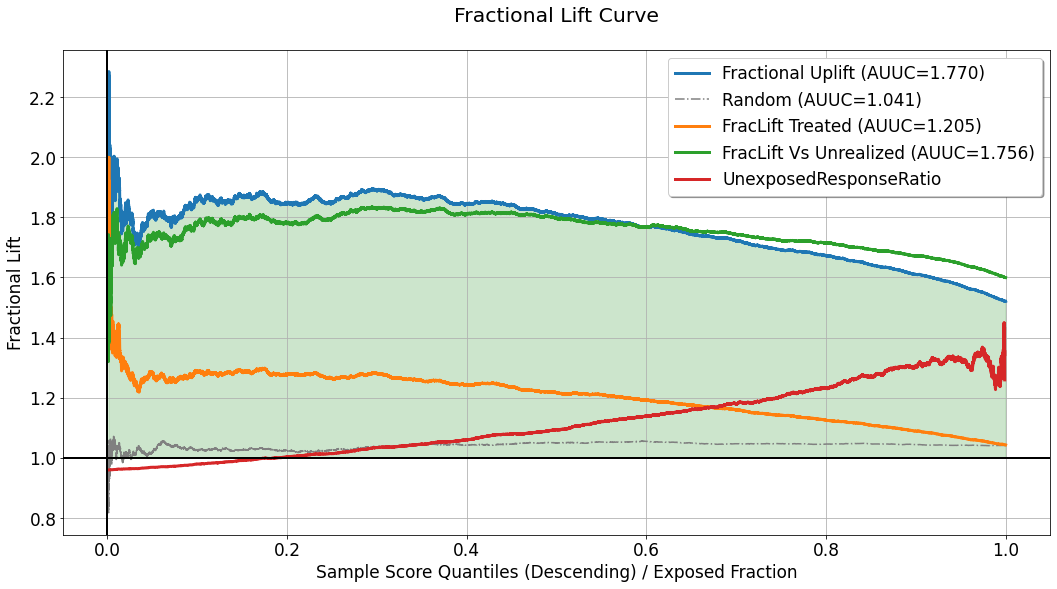

In [24]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['fractional_lift'])

In some use-cases, especially these in which the response variable is continuous, telling the <ins>difference</ins> in average response between groups might not be enough. In such cases, telling the percentage increase in average response in one group compared to another can be more useful. The ***fractional lift*** chart provides visualization of average response ratios, which reflect the percentage increase/decrease associated with treatment assignment (or the avoidance of which). This chart replaces the <ins>difference/substraction</ins> opeartion used for the calculation of the curves depicted in the [uplift chart](#Uplift-Curve), and computes the ratio of average responses between the same "*confronted*" sections. For a detailed explanation of the quantities used to compute every curve in this chart, refer to the explanation for the [uplift chart](#Uplift-Curve).

### Gain Curve

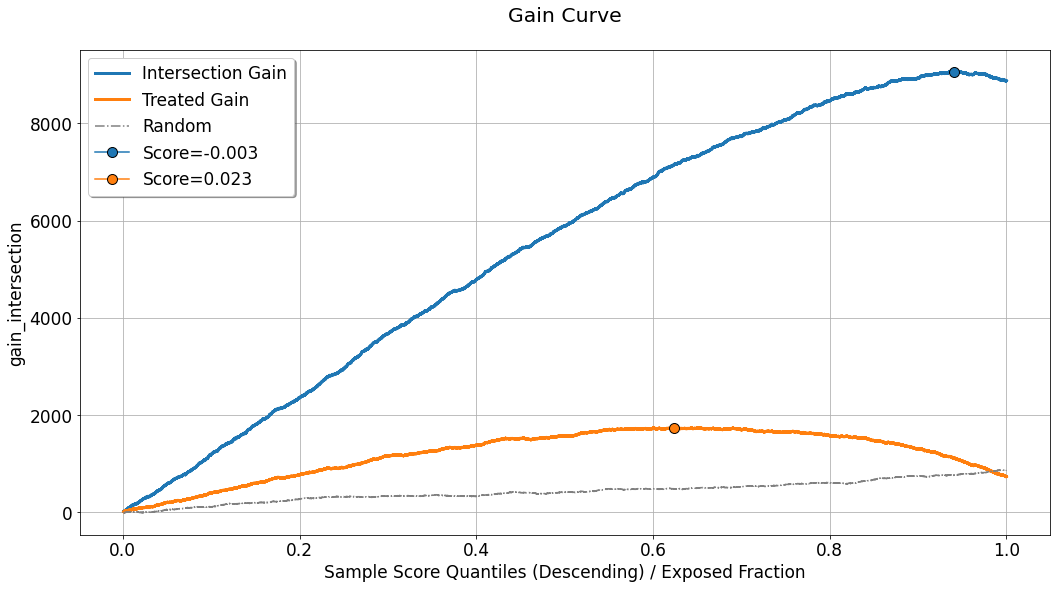

In [25]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['gain'])

In the `uplift-analysis` framework, we use the term `gain`, to describe the absolute quantitative result / benefit implied by the calculated uplift for the evaluated set. It can be interpreted differently in the case of a binary response variable, or a continuous one.<br/>
Assuming the estimate of the uplift signal is reliable, and for the evaluated set we have $N_{t_0}(q^{*})$ untreated instances falling inside the acceptance region (defined by $\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}})$). If we were to apply the uplift model using the threshold $Thresh(q^{*},\boldsymbol{\hat{u}})$ on the same specific evaluated set, the question will be:

- In the case of a binary response variable: how many instances can we expect to change their response from $0$ to $1$?
- In the case of a continuous variable: what will be the total increase in the response for these $N_{t_0}(q^{*})$ instances, if they were exposed to the recommendations of the model?

For calculating this we multiply the uplift signal (estimated and shown in the [uplift chart](#Uplift-Curve)) by the quantity of untreated instances, for each $q^{*}$, and the corresponding threshold $Thresh(q^{*},\boldsymbol{\hat{u}}) = p_{q^{*}}$:
$$
\begin{align}
Gain(q^{*}) =
\end{align}
$$
$$
\begin{align}
\left( \frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i > p_{q^{*}} \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq p_{q^{*}} \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]} - \frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq p_{q^{*}} \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq p_{q^{*}} \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]} \right) \cdot
\left(\sum_{i} \mathbb{1} \left[\hat{u}_i \geq p_{q^{*}} \right] \cdot  \mathbb{1} \left[t^{(i)} = t_0 \right] \right)=
\end{align}
$$
$$
\begin{align}
Uplift(q^{*})\cdot N_{t_0}(q^{*})
\end{align}
$$

Although in the specific chart shown above, the depicted curve seems to rise almost for the entire range of $q^{*}$, in practice this curve might be shaped differently in other scenarios. For example, if the uplift curve is descending, but positive, as a function of $q^{*}$, then although $N_{t_0}(q^{*})$ is monotonically increasing w.r.t $q^{*}$, the decrease in the uplift signal might shape the gain curve as a bell-shaped curve.<br/> 
Here comes in to the picture the choice of the [<ins>*operating point*</ins>](#Inspect-Operating-Point-Treatment-Assignment-Distribution). One might want to set the operating point, with a threshold that corresponds to the maximal gain. Thus, this chart highlights the maximal gain point with a marker, labeled with the corresponding score threshold value, in order to facilitate the choice of operating point.

As for the previous charts, the curve labeled as `Random` depicts the average gain curve computed for `num_random_rep` randomly scored evaluation sets, and can be used as a benchmark for understanding whether the performance observed in our primary evaluated set is coincidential or not.

Another curve displayed in this chart is labeled as `Treated Gain`. It is relevant only in the case where the evaluated set is associated with multiple treatments. It is used to describe and quantify the gain associated with a scenario in which all the non-neutral actions, $t \neq t_0$, are treated as a single treatment. Just like in the [uplift chart](#Uplift-Curve), the gap between `Intersection Gain` and `Treated Gain`, can emphasize the need in considering each treatment separately. The maximal point for this gain curve is also highlighted and labeled with the corresponding score threshold value.

### Expected Response

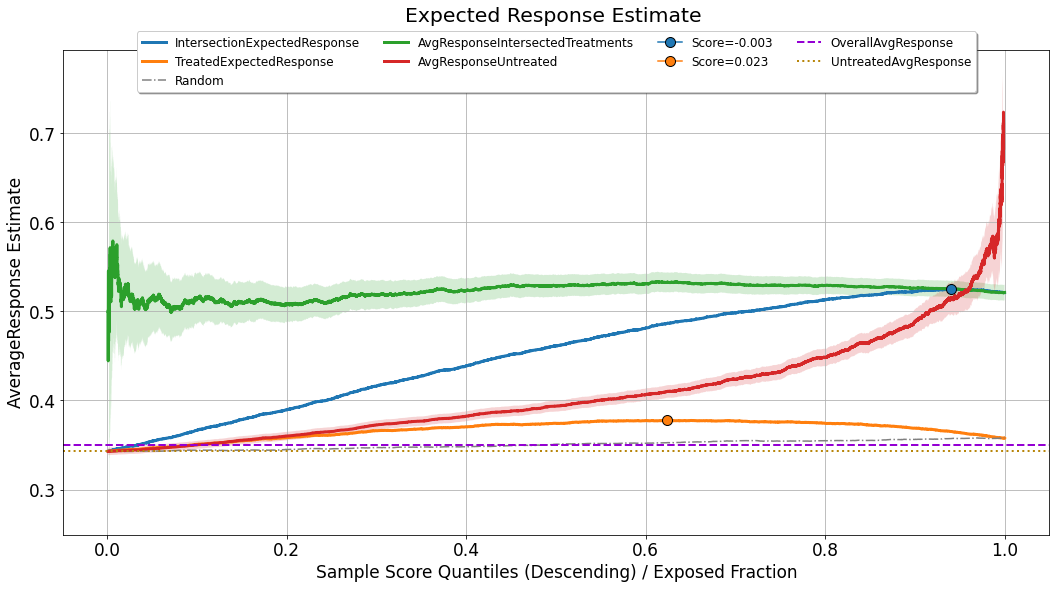

In [26]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['avg_response'])

Although the analysis of uplift models focuses primarily on statistics computed inside the acceptance region, what we would like to achieve eventually is a model (and a corresponding operating point) which will maximize the expected value of the response for the <ins>entire population<ins>.<br/>
For doing so, we assume that the distribution of uplift scores and response values observed in the evaluated set, provides a good representation and reflection of the distribution the model will meet upon deployment. In such a case, the expected response can be seen as a weighted average between two factors:
    
- the **average response** for the group of observations for which the <ins>observed actions intersect with the treatments recommended</ins> by the model, in the <ins>acceptance region</ins>: $\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[h_{q^{*}}(x^{(i)}) = t^{(i)} \right]}$. This curve is labeled as `AvgResponseIntersectedTreatments`.

- the **average response** for the <ins>untreated</ins> group of observations,which fall in the <ins>rejection region</ins>: $\frac{\sum_{i} y_i \mathbb{1} \left[\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}{\sum_{i} \mathbb{1} \left[\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[t^{(i)} = t_0 \right]}$. This curve is labeled as `AvgResponseUntreated`.

As can be seen in the chart, both of these curves are bounded by uncertainty sleeves. These sleeves represent a $95\%$ confidence interval associated with the standard error of either the mean estimator (when the response variable is continuous), or the proportion estimator (when the response variable is binary).

For estimating the expected response associated with the operating point $q^{*}$, we weigh these two curves by the following:
$$
\begin{align}
q^{*} \cdot AvgResponseIntersectedTreatments(q^{*}) + \left( 1-q^{*} \right) \cdot AvgResponseUntreated(q^{*})
\end{align}
$$
As this curve takes into account an aggregation of the performance of the model across the entire distribution of scores, and just like the [gain curve](#Gain-Curve), it might not (and it probably won't) be monotonically increasing, it can also be used for setting the optimal [operating point](#Inspect-Operating-Point-Treatment-Assignment-Distribution).

For benchmarking purposes, this chart also displays:
    
- `TreatedExpectedResponse` - The same logic applied for the computation of `IntersectionExpectedResponse`, but when all the non-neutral treatments are considered as a single treatment.
- `Random` - The same logic as in `IntersectionExpectedResponse`, applied to a set of randomly scored evaluation sets, and then averaged.
- `OverallAvgResponse` - The average response observed across the entire evaluation set (fixed value, not affected by a specific choice of operating point).
- `UntreatedAvgResponse` - The average response observed across the untreated observations in the evaluation set (fixed value, not affected by a specific choice of operating point).

### Acceptance and Rejection Regions

Recall that the uplift signals depicted in the [uplift chart](#Uplift-Curve) are subtractions of mean/proportion estimators of the response in the acceptance region. Therefore it could be useful to examine these source signals directly.

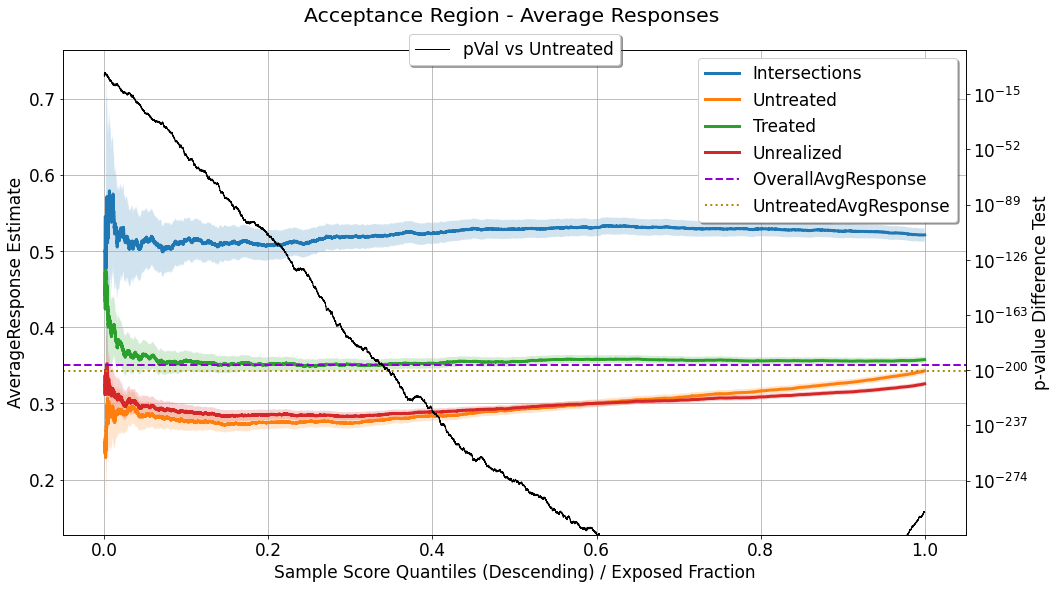

In [27]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['acceptance_region'])

In this chart we can see a few mean/proportion estimate signals, as a function of $q^{*}$, all of which are computed for observations with $\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}})$:

- `Intersections`: where $h_{q^{*}}(x^{(i)}) = t^{(i)}$.
- `Untreated`: where $t^{(i)} = t_0$.
- `Treated`: where $t^{(i)} \neq t_0$ (relevant only in multiple actions scenario).
- `Unrealized`: where $t^{(i)} \neq h_{q^{*}}(x^{(i)})$ (relevant only in multiple actions scenario).

Because all these signals, for a certain $q^{*}$, are estimators of mean response / response proportion (depending on the type of response variable), all of them are accompanied by an uncertainty sleeve, depicting a $95\%$ confidence interval associated with the corresponding standard error. As we move along the curves towards the right side of the chart, the acceptance region goes wider, and these curves (mean/proportion estimators) include more observations for computing the statistics, the uncertainty decreases, and the sleeves go narrower.

In addition, this chart depicts the result of a statistical hypothesis test for the difference in average response between the `Intersections` group and the `Untreated` group. The null hypothesis used for this test is that the average response for the two groups is equal, and the alternative hypothesis is that it is different (a two-tailed test). When the response variable is continuous a [t-test](https://stattrek.com/hypothesis-test/difference-in-means.aspx?tutorial=AP) is used for testing the difference in means, and when the response variable is binary a [proportion test](https://stattrek.com/hypothesis-test/difference-in-proportions.aspx) is used. As a result of the test performed for each $q^{*}$, we get a corresponding `p-value`, which quantifies the probability that similar findings will be found in case the null hypothesis is true. The `p-value` associated with each $q^{*}$ is depicted and associated with the right *y-axis* ; as it goes lower it implies that the difference between the estimators is more significant.

Again, just as in the [*Expected Response* chart](#Expected-Response), the values of `OverallAvgResponse` and `UntreatedAvgResponse` are shown as a reference for comparison as well. 

For the complete picture, one can also examine the estimators of average response in the rejection region:

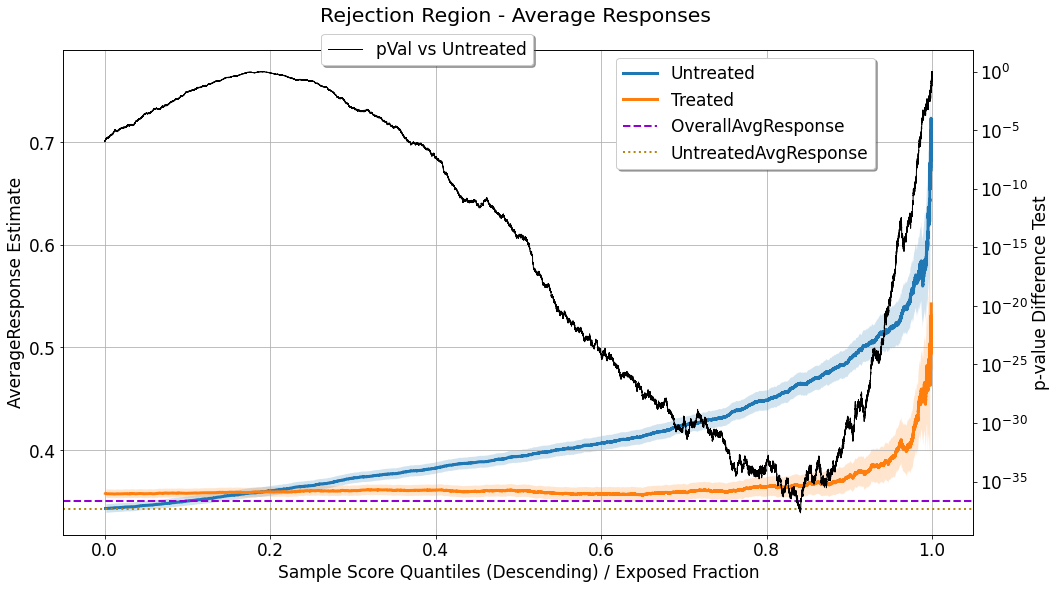

In [28]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['rejection_region'])

In this chart we can see two mean/proportion estimate signals, as a function of $q^{*}$, both of which are computed for observations, in the rejection region, with $\hat{u}_i < Thresh(q^{*},\boldsymbol{\hat{u}})$:

- `Untreated`: where $t^{(i)} = t_0$.
- `Treated`: where $t^{(i)} \neq t_0$.

As opposed to the previous chart, here the uncertainty sleeves get wider as we consider a higher value of $q^{*}$, because a higher value of $q^{*}$ implies a narrower rejection region, so these estimates end up relying on less observations.

Similarly to the previous chart, a statistical hypothesis test is applied for testing the difference in average response between the groups mentioned above, and its outcomes, the p-values, are shown (corresponding to right *y-axis*).

### Agreement Statistics

As explained earlier, our ability to *interpolate* the observed tuples structured as $(context, treatment, response)$, and estimate the response for an unseen combination of $context$ and $treatment$, depends, among the rest, on the controlled randomization in the data collection phase.<br/>
The evaluated performance shown on the previous chart, relies heavily on the instances for which the recommendation of the model *matches* the assigned treatment during the data collection phase.<br/>
If these intersections occur in significantly different rates along the distribution of uplift scores, it might imply that:

- The assignment of treatments was not completely random - some information, that is also contained in the covariates the model is exposed to, affected the probability of treatment assignment per instance.
- Or that some leakage of treatment-assignment-related information finds its way, through the covariates, to the model, and affects the distribution of uplift scores for the treated group.

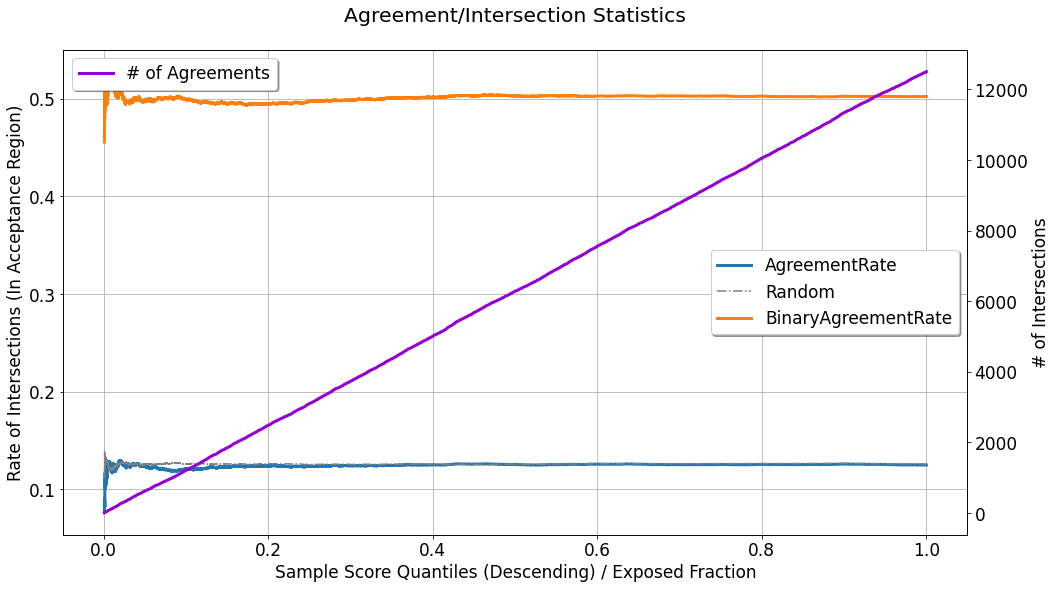

In [29]:
evaluator.visualize(eval_res,show_random=True,num_random_rep=4,specify=['agreements'])

This chart depicts `AgreementRate`, which shows the rate in which these <ins>agreements</ins> / <ins>intersections</ins> occur, as a function of acceptance region width (controlled by $q^{*}$):
$$
\begin{align}
\frac{1}{N_{q^{*}}} \sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[ h_{q^{*}}(x^{(i)}) = t^{(i)} \right]
\end{align}
$$
where $N_{q^{*}}$ denotes the total quantity of observations in the acceptance region.<br/>
In the displayed curve, the rate seems to be almost perfectly uniform w.r.t to $q^{*}$ (except for the noise in the narrow acceptance region, associated with smaller $q^{*}$ values). In the scenario brought here in the tutorial, the generated data is synthetic, and the simulated treatment assignment can be easily randomized, but in practice, this will not always be the case, and this figure can be used to point out imperfections in the randomization of treatment assignment. <br/>
Also displayed in the chart is the curve labeled as `# of Agreements` which is the cumulative count of agreements found as $q^{*}$ grows bigger. Non-linear growth in this monotonically increasing curve might also imply the same leakage or imperfect randomization mentioned above.

As a benchmark, one can also refer to the curves:

- `Random`: The average agreement rate observed across (possibly multiple) randomly scored evaluation sets.
- `BinaryAgreementRate`: The agreement rate computed where the set of non-neutral treatments ($t^{(i)} \neq t_0$), are treated as a single treatment:
$$
\begin{align}
\frac{1}{N_{q^{*}}} \sum_{i} \mathbb{1} \left[\hat{u}_i \geq Thresh(q^{*},\boldsymbol{\hat{u}}) \right] \cdot \mathbb{1} \left[ t^{(i)} \neq t_0 \right]
\end{align}
$$
It will be displayed only in case the evaluated set is associated with multiple treatments.

## Compare Evaluated Performance Between `EvalSet`s

The visualizations shown above do provide a lot of performance-related information. However, it visualizes the performance for a single `EvalSet` object. In practice, we may want to compare the performance of multiple experiments at once.<br/>
For demonstration, let us create a dictionary of evaluation sets, corresponding to the *T-learner* models associated with the continuous response variable:

In [30]:
compare_eval_sets = {} # will contain the two evaluation sets

for model_name,field_name in zip(['t_gbdt','t_linear'],['t_learner_gbdt_cont','t_learner_linear_cont']):
    # create `Scorer` object
    scorer = scoring.Scorer({'name': model_name,
                             'scoring_field': field_name,
                             'reference_field': field_name,
                             'reference_idx': 0,
                             'scoring_func': 'cont_score_calc'})
    
    
    ranking, recommended_action, score, action_dim = scorer.calculate_scores(dataset=valid_set)
    scored_df = pd.DataFrame(
            {
                'recommended_action': recommended_action,
                'score': score,
                'observed_action': valid_set['treatments'],
                'response': valid_set['response']
            }
        )
    compare_eval_sets[model_name] = data.EvalSet(df=scored_df,
                                   name=model_name,
                                   observed_action_field='observed_action',
                                   response_field='response',
                                   score_field='score',
                                   proposed_action_field='recommended_action',
                                   control_indicator=0)

<ins>Notes:</ins>
- In this demonstration the evaluation sets we compare represent different models applied to the same dataset. However, there is no such restriction, and we can use the following comparison flow, for evaluation sets representing different datasets, if it makes sense. For example, we might want to inspect the performance of a single model, applied to different datasets, which can be associated with different population segments, or different time periods.
- There is no limitation on number of evaluation sets to compare.

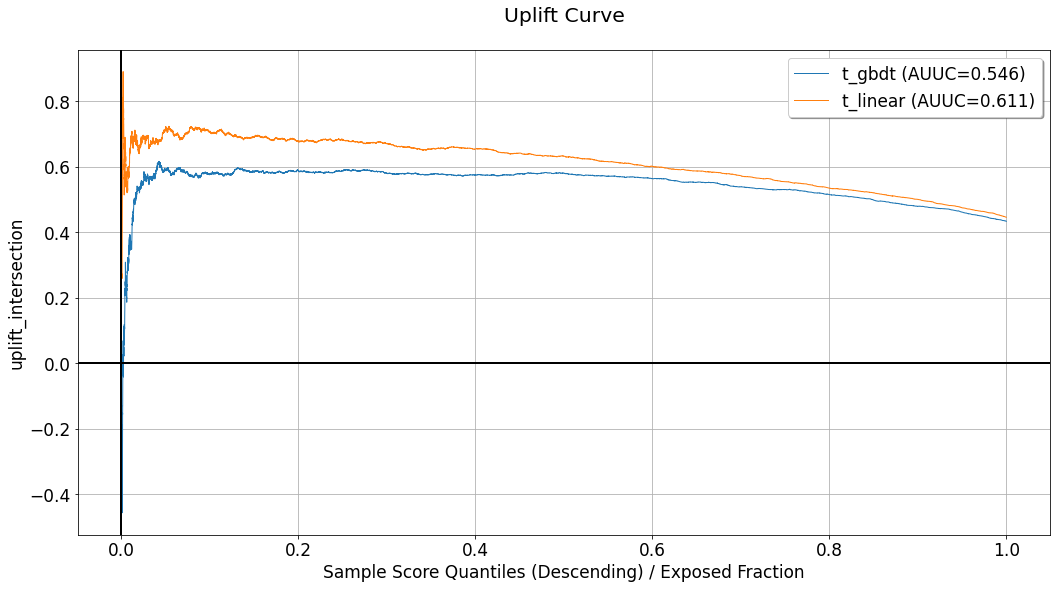

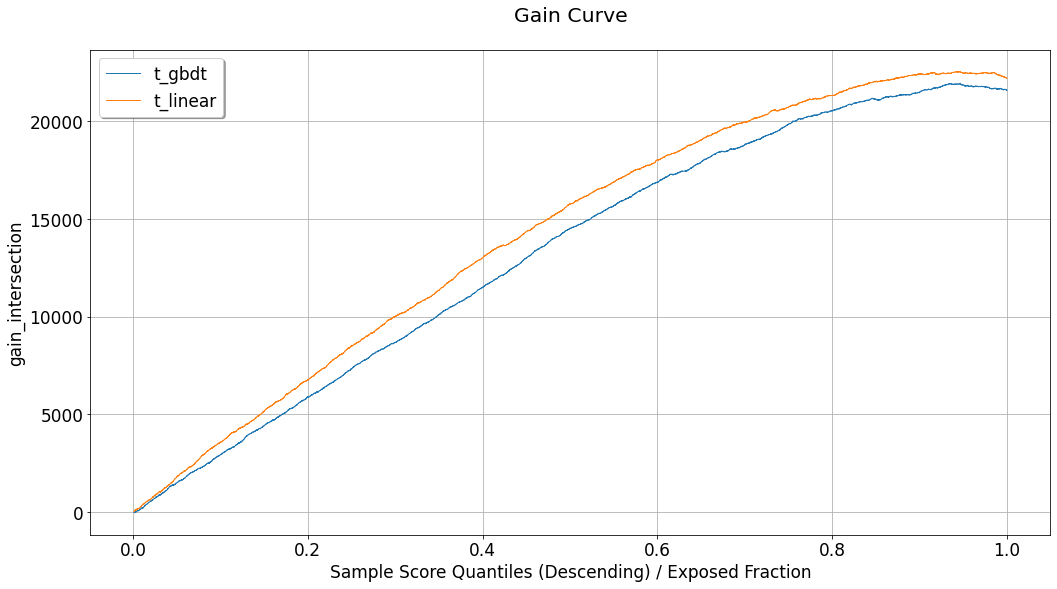

In [31]:
evaluator = evaluation.Evaluator()
compare_eval_sets, summary = evaluator.eval_and_show(compare_eval_sets,specify=['uplift','gain'])

Using the charts we can observe the evaluated performance associated with each of the evaluation sets contained in `compare_eval_sets`.<br/>
As opposed to evaluation and visualization of a single `EvalSet` object, when multiple sets are considered, only a single curve is dedicated for each evaluation set, in each chart. These will be:

- [Uplift chart](#Uplift-Curve): `Intersection Uplift`.
- [Fractional lift chart](#Fractional-Lift-Curve): `Fractional Uplift`.
- [Gain chart](#Gain-Curve): `Intersection Gain`.
- [Expected response chart](#Expected-Response): `IntersectionExpectedResponse`.
- [Acceptance and Rejection regions charts](#Acceptance-and-Rejection-Regions): `Intersections`.
- [Agreement statistics chart](#Agreement-Statistics): `AgreementRate`.

## Average Performance Across Multiple Evaluation Sets

In some cases, we might want to inspect the average performance across multiple evaluation sets. For example, the multiple evaluation sets might represent different random seeds associated either with the data generation process or with the base models composing the meta-learner.<br/>

For this demonstration let us train *T-learners* trained and evaluated on new randomized datasets (each time using a different random seed), and average the performance across the corresponding evaluation sets:

In [32]:
random_seeds = [111, 222, 333, 444, 555]
avg_eval_sets = dict()

for random_seed in tqdm(random_seeds):

    action_dependent_models = []
    action_dependent_outputs = []
    
    # get sets
    np.random.seed(random_seed)
    train = dg.generate(num_samples)
    valid = dg.generate(num_samples)    

    # for each treatment
    for treat in range(num_treatments + 1):
        # get the subset of observations related to the treatment
        subset_idx = train['treatments'] == treat

        # train the treatment-dependent response model
        action_dependent_models.append(GradientBoostingRegressor(n_estimators=10).fit(
            X=train['features'][subset_idx],
            y=train['response'][subset_idx]))
        # apply to the validation set
        action_dependent_outputs.append(action_dependent_models[treat].predict(valid['features']))

    # stack outputs
    valid[f"seed_{random_seed}"] = np.stack(action_dependent_outputs, axis=-1)

    # create `Scorer` object
    scorer = scoring.Scorer({'name': f"seed_{random_seed}",
                             'scoring_field': f"seed_{random_seed}",
                             'reference_field': f"seed_{random_seed}",
                             'reference_idx': 0,
                             'scoring_func': 'cont_score_calc'})

    ranking, recommended_action, score, action_dim = scorer.calculate_scores(dataset=valid)
    scored_df = pd.DataFrame(
        {
            'recommended_action': recommended_action,
            'score': score,
            'observed_action': valid['treatments'],
            'response': valid['response']
        }
    )
    avg_eval_sets[f"seed_{random_seed}"] = data.EvalSet(df=scored_df,
                                                         name=f"seed_{random_seed}",
                                                         observed_action_field='observed_action',
                                                         response_field='response',
                                                         score_field='score',
                                                         proposed_action_field='recommended_action',
                                                         control_indicator=0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:24<00:00, 16.93s/it]


Then for averaging, we simply need to send `average=True`, to the evaluator:

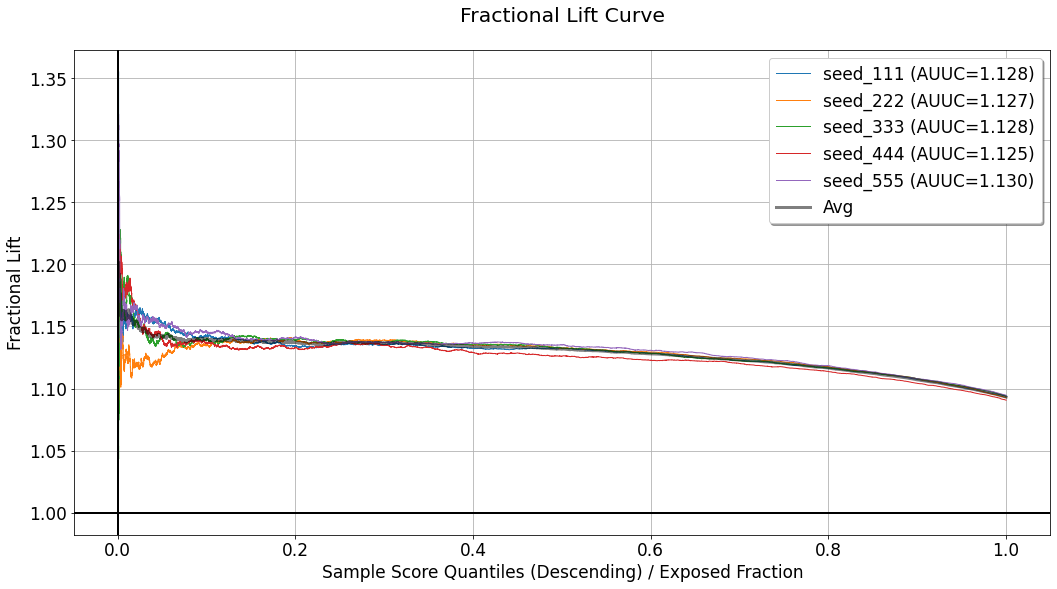

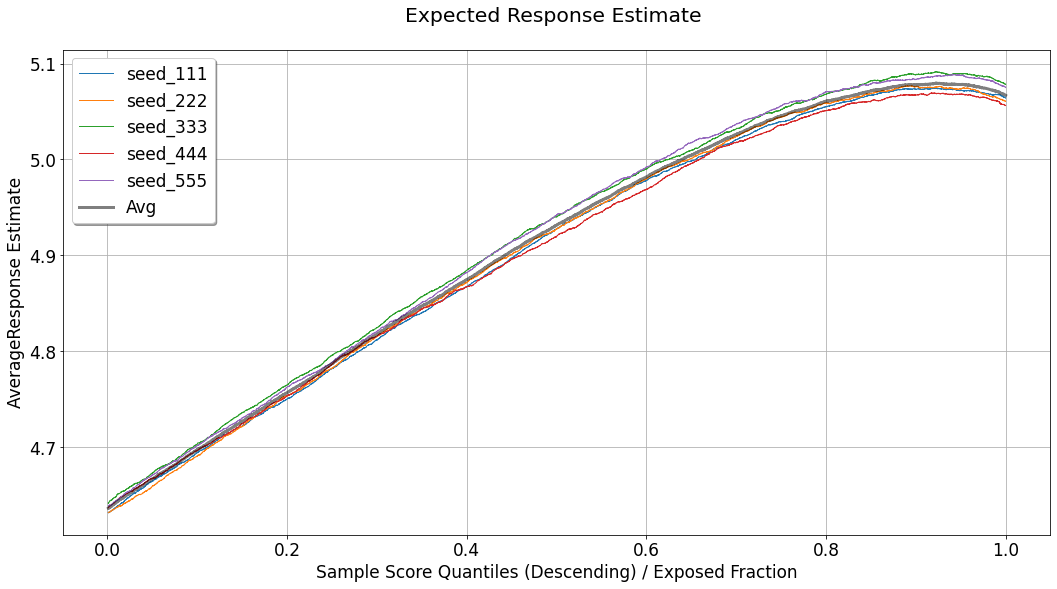

In [33]:
e,s = evaluator.eval_and_show(avg_eval_sets,average=True,specify=['fractional_lift','avg_response'])

In that case, the wide gray line represents the average performance across the seeds.

## Evaluation Summaries

When applying the evaluation procedure using an `Evaluator` object, we get in return a summary of the aggregate performance measured as part of the evaluation.

In [34]:
_, single_summary = evaluator.evaluate_set(eval_set)
_, multi_summary = evaluator.evaluate_multiple(compare_eval_sets)

The `single_summary` is a `dict`:

In [35]:
for k,v in single_summary.items():
    print(f"{k} : {v:.2f}")

intersect_AUUC : 0.23
intersect_max_avg_resp : 0.52
max_relative_lift_intersect : 0.18
intersect_max_gain : 9063.24
treated_AUUC : 0.06
treated_max_avg_resp : 0.38
max_relative_lift_treated : 0.03
treated_max_gain : 1739.44


while the `multi_summary` is a pandas dataframe, allowing to observe the aggregate performance across multiple evaluation sets:

In [36]:
multi_summary

,intersect_AUUC,intersect_max_avg_resp,max_relative_lift_intersect,intersect_max_gain,treated_AUUC,treated_max_avg_resp,max_relative_lift_treated,treated_max_gain
t_gbdt,0.546067,5.068639,0.440621,21939.330516,0.107946,4.695551,0.067534,3355.064437
t_linear,0.610636,5.080676,0.452659,22538.792154,0.112413,4.691894,0.063876,3174.949781


The measures listed in these summaries are:

- `intersect_AUUC`: The area under the uplift curve (i.e. its integral), shown in the [uplift chart](#Uplift-Curve).
- `intersect_max_avg_resp`: The maximal expected response computed, corresponding to the [expected response chart](#Expected-Response).
- `max_relative_lift_intersect`: The maximal difference between the expected response curve, and the average response observed for the untreated group (across the entire dataset), which is labeled as `UntreatedAvgResponse` in the [expected response chart](#Expected-Response).
- `intersect_max_gain`: The maximal gain computed, corresponding to the [gain chart](#Gain-Curve).

The other metrics will be included in the summary only for evaluation sets associated with multiple actions. Their names will include the replacement of `intersect` with `treated`, and they reveal the same logic explained above, applied in the case where the set of the multiple non-neutral actions are considered as a single treatment.